# Investigating feature importance scores from production classifiers
**Author:** Jessica Ewald <br>

In the scrambled controls, the REF-REF, VAR-VAR, and REF-VAR classifiers all seemed to learn the same signature (we assume related to well position). Here, the objective is to analyze the feature importance scores from the production classifiers in the same way, comparing the mean feature importance rank across perturbation and null classifiers for both the protein and non-protein features.

In [1]:
# Imports
import pathlib
import polars as pl
import pandas as pd
import numpy as np
from scipy import stats
import os
import seaborn as sns
import matplotlib.pyplot as plt

import black
import jupyter_black

jupyter_black.load(
    lab=False,
    line_length=79,
    verbosity="DEBUG",
    target_version=black.TargetVersion.PY310,
)

import warnings
warnings.filterwarnings("ignore")

DEBUG:jupyter_black:config: {'line_length': 79, 'target_versions': {<TargetVersion.PY310: 10>}}


<IPython.core.display.Javascript object>

In [2]:
data_dir = "/dgx1nas1/storage/data/sam/results/Run7/"

feature_sets = ["non_protein", "protein"]
comparisons = ["control_feat_importance", "feat_importance"]
comp_dict = {'control_feat_importance': 'Controls',
             'feat_importance': 'WT_VAR'}


In [3]:
# concatenate all FIP results
feat_imp = pl.DataFrame()
for fs in feature_sets:
    for comp in comparisons:
        
        df = pl.read_csv(f'{data_dir}/2023_05_30_B1A1R1_{fs}_{comp}_normalized_feature_selected.csv').with_row_index()
            
        df = df.melt(id_vars = ['Gene', 'Variant', 'index']).with_columns(pl.lit(fs).alias("Feature_Set"),
                                                                 pl.lit(comp_dict[comp]).alias('Comparison'))
        feat_imp = pl.concat([feat_imp, df], how = "vertical")

In [4]:
# Add unique identifier
feat_imp = feat_imp.with_columns(pl.concat_str([pl.col("Gene"), pl.col("Variant"), pl.col("Feature_Set"), pl.col("Comparison"), pl.col("index")], separator="_").alias("ClassifierID"))

# Add rank of feature within each classifier
feat_imp = feat_imp.with_columns(pl.col("value").rank(descending=True).over("ClassifierID").alias("FIP_rank"))

In [10]:
# summarize ranks
imp_summary = feat_imp.group_by(["variable", "Feature_Set", "Comparison"]).agg(pl.col("FIP_rank").mean().alias("mean_VIP"))
prot_summary = imp_summary.filter(pl.col("Feature_Set") == "protein").pivot(index="variable", columns="Comparison", values="mean_VIP")
nonprot_summary = imp_summary.filter(pl.col("Feature_Set") == "non_protein").pivot(index="variable", columns="Comparison", values="mean_VIP")

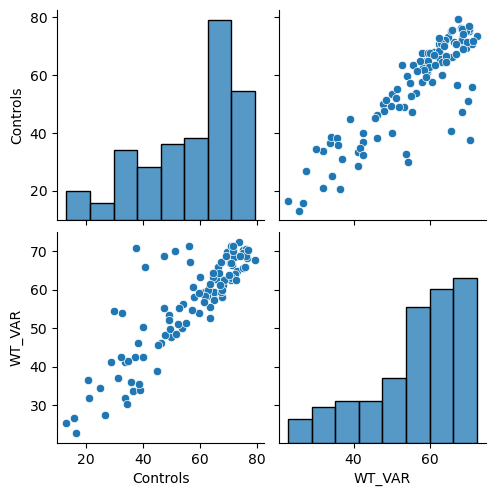

In [11]:
sns.pairplot(prot_summary.to_pandas())

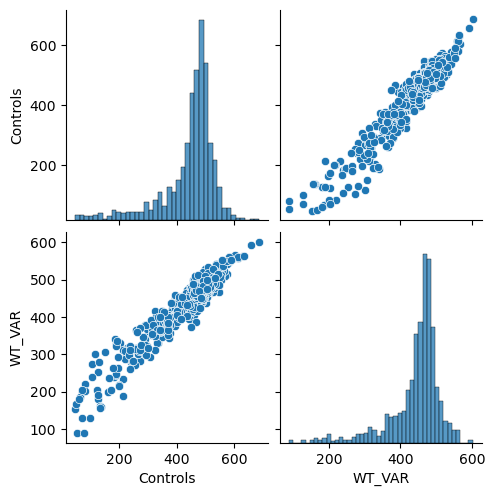

In [12]:
sns.pairplot(nonprot_summary.to_pandas())